In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

from DataGenerator import *
from Competition import *
from config import *
from utils.common_helpers import set_protected_groups, confusion_matrix_metrics

In [2]:
BN_EO = initialize_BN()
dataset = BN_EO.simulate(n_samples=50000, seed=SEED)

  0%|          | 0/8 [00:00<?, ?it/s]

In [3]:
dataset

,SES,JOB,COLLEGE,SCHOOL,SEX,SAT,INTERN,CGPA
0,2,1,1,1,1,2,1,2
1,2,0,0,2,1,1,1,2
2,0,0,0,1,1,1,1,2
3,1,0,0,1,1,2,0,0
4,2,0,0,1,0,2,0,0
...,...,...,...,...,...,...,...,...
49995,0,0,0,0,0,0,0,1
49996,2,1,1,1,0,1,1,1
49997,1,1,1,0,0,0,1,1
49998,2,1,1,1,1,1,1,2


In [4]:
dataset.columns

Index(['SES', 'JOB', 'COLLEGE', 'SCHOOL', 'SEX', 'SAT', 'INTERN', 'CGPA'], dtype='object')

In [7]:
competition1 = dataset[['SAT', 'SEX', 'COLLEGE','SCHOOL', 'SES' ]]

In [8]:
train, test = train_test_split(competition1, test_size=0.2, random_state=SEED)

train

In [10]:
train.SAT.sort_values()

14227    0
19932    0
48519    0
37537    0
36727    0
        ..
32569    2
17104    2
12482    2
10921    2
19645    2
Name: SAT, Length: 40000, dtype: int64

In [44]:
data = set_protected_groups(dataset, ['SEX', 'SES'], [0,0])
print(data.keys())

base_rates = {}
for group in data.keys():
    base_rates[group] = {}

competitions = ['COLLEGE', 'INTERN', 'JOB']

for competition in competitions:
    for group in data.keys():
        base_rates[group][competition] = data[group][data[group][competition] == 0].shape[0]/data[group].shape[0]
        
pd.DataFrame(base_rates)

dict_keys(['SEX-SES_priv', 'SEX-SES_dis', 'SEX_priv', 'SEX_dis', 'SES_priv', 'SES_dis'])


,SEX-SES_priv,SEX-SES_dis,SEX_priv,SEX_dis,SES_priv,SES_dis
COLLEGE,0.862272,0.362440,0.512106,0.286350,0.767586,0.336722
INTERN,0.811362,0.433126,0.597079,0.299590,0.669674,0.430882
JOB,0.835131,0.460493,0.631395,0.315479,0.745692,0.445757


In [7]:
C1_label = 'COLLEGE'
C1_features = ['SES', 'SEX', 'SAT', 'SCHOOL']
C1 = Competition(dataset, C1_features, C1_label, ['SEX', 'SES'], [0,0])

In [8]:
dataset[C1.target].value_counts()

1    28913
0    21087
Name: COLLEGE, dtype: int64

In [9]:
X_train, y_train, X_test, y_test, X_val, y_val = C1.create_train_test_val_split(SEED=450)
X_train.shape, X_test.shape, X_val.shape

((30000, 4), (10000, 4), (10000, 4))

In [10]:
C2_label = 'INTERN'
C2_features = ['SES', 'SEX', 'SAT', 'SCHOOL','COLLEGE','CGPA']
C2 = Competition(dataset, C2_features, C2_label, ['SEX', 'SES'], [0,0])

In [11]:
C3_label = 'JOB'
C3_features = ['SES', 'SEX', 'SAT', 'SCHOOL','COLLEGE','CGPA','INTERN']
C3 = Competition(dataset, C2_features, C2_label, ['SEX', 'SES'], [0,0])

In [12]:
for i in C1.protected_groups.keys():
    print(i, C1.protected_groups[i].shape[0]/C1.X_data.shape[0])

SEX-SES_priv 0.11864
SEX-SES_dis 0.88136
SEX_priv 0.59972
SEX_dis 0.40028
SES_priv 0.19732
SES_dis 0.80268


In [22]:
best_models = {}
#for model_name in model_specs.keys():
for model_name in ['dtc']:
    print(model_name)
    search = GridSearchCV(model_specs[model_name]["base_model"], model_specs[model_name]["params"], cv=5, n_jobs=-1, verbose=True)
    model = search.fit(X_train, y_train)
    best_models[model_name] = model.best_estimator_
    
best_models

dtc
Fitting 5 folds for each of 72 candidates, totalling 360 fits


{'dtc': DecisionTreeClassifier(ccp_alpha=0.001, max_depth=5, random_state=111)}

In [23]:
res = {}
for model_name in best_models.keys():
    y_preds = best_models[model_name].predict(X_val)
    res[model_name] = confusion_matrix_metrics(y_val, y_preds)
    
pd.DataFrame(res)

,dtc
Accuracy,0.760400
F1,0.704853
FNR,0.316041
FPR,0.184631
PPV,0.727065
Positive-Rate,0.940712
Selection-Rate,0.393500
TNR,0.815369
TPR,0.683959


In [24]:
best_model = best_models['dtc']

In [25]:
C1_predicted_scores = best_model.predict_proba(C1.X_data)[:,0]

In [26]:
C1.protected_groups.keys()

dict_keys(['SEX-SES_priv', 'SEX-SES_dis', 'SEX_priv', 'SEX_dis', 'SES_priv', 'SES_dis'])

In [27]:
def get_threshold(alpha, scores):
    n = len(scores)
    scores.sort()
    pos = int((n+1)*(1-alpha))
    
    return scores[pos]

In [32]:
for group in C1.protected_groups.keys():
    scores = C1_predicted_scores[C1.protected_groups[group].index]
    thr = get_threshold(0.25, scores)
    # 0 is the positive outcome in the generated set, so following the same convention here
    labels = [int(x<thr) for x in scores]
    C1.protected_groups[group]['COLLEGE_'+group.split("_")[0]] = labels
    
    #print(group, get_threshold(0.25, scores))

/var/folders/hv/l0r_7qdd1klgjs1kp27qyjqc0000gn/T/ipykernel_41952/2732817075.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  C1.protected_groups[group]['COLLEGE_'+group.split("_")[0]] = labels


In [42]:
dataset['COLLEGE_SES'] = pd.concat([C1.protected_groups['SES_dis'], C1.protected_groups['SES_priv']])['COLLEGE_SES']
dataset['COLLEGE_SEX'] = pd.concat([C1.protected_groups['SEX_dis'], C1.protected_groups['SEX_priv']])['COLLEGE_SEX']
dataset['COLLEGE_SEX-SES'] = pd.concat([C1.protected_groups['SEX-SES_dis'], C1.protected_groups['SEX-SES_priv']])['COLLEGE_SEX-SES']

In [43]:
dataset

,JOB,CGPA,SCHOOL,SAT,INTERN,SEX,SES,COLLEGE,COLLEGE_SES,COLLEGE_SEX,COLLEGE_SEX-SES
0,1,2,1,2,1,1,2,1,1,1,1
1,0,2,2,1,1,1,2,0,1,1,1
2,0,2,1,1,1,1,0,0,1,1,1
3,0,0,1,2,0,1,1,0,1,1,1
4,0,0,1,2,0,0,2,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
49995,0,1,0,0,0,0,0,0,0,0,0
49996,1,1,1,1,1,0,2,1,0,0,0
49997,1,1,0,0,1,0,1,1,0,0,0
49998,1,2,1,1,1,1,2,1,0,0,0


In [45]:
data = set_protected_groups(dataset, ['SEX', 'SES'], [0,0])
print(data.keys())

base_rates = {}
for group in data.keys():
    base_rates[group] = {}

competitions = ['COLLEGE', 'COLLEGE_SES', 'COLLEGE_SEX', 'COLLEGE_SEX-SES']

for competition in competitions:
    for group in data.keys():
        base_rates[group][competition] = data[group][data[group][competition] == 0].shape[0]/data[group].shape[0]
        
pd.DataFrame(base_rates)

dict_keys(['SEX-SES_priv', 'SEX-SES_dis', 'SEX_priv', 'SEX_dis', 'SES_priv', 'SES_dis'])


,SEX-SES_priv,SEX-SES_dis,SEX_priv,SEX_dis,SES_priv,SES_dis
COLLEGE,0.862272,0.362440,0.512106,0.286350,0.767586,0.336722
COLLEGE_SES,0.638065,0.312994,0.349663,0.354402,0.643118,0.279887
COLLEGE_SEX,0.501517,0.397976,0.504469,0.269112,0.407359,0.410973
COLLEGE_SEX-SES,0.901214,0.277571,0.400053,0.278905,0.651328,0.277869


In [46]:
dataset

,JOB,CGPA,SCHOOL,SAT,INTERN,SEX,SES,COLLEGE,COLLEGE_SES,COLLEGE_SEX,COLLEGE_SEX-SES
0,1,2,1,2,1,1,2,1,1,1,1
1,0,2,2,1,1,1,2,0,1,1,1
2,0,2,1,1,1,1,0,0,1,1,1
3,0,0,1,2,0,1,1,0,1,1,1
4,0,0,1,2,0,0,2,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
49995,0,1,0,0,0,0,0,0,0,0,0
49996,1,1,1,1,1,0,2,1,0,0,0
49997,1,1,0,0,1,0,1,1,0,0,0
49998,1,2,1,1,1,1,2,1,0,0,0


In [ ]:
C1.protected_groups.keys()

In [ ]:
scores

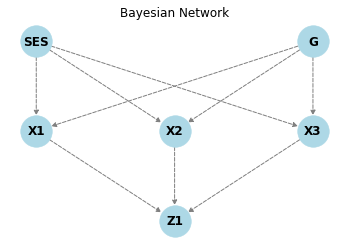

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
graph = nx.DiGraph()

# Add nodes
graph.add_nodes_from(["SES", "G", "X1", "X2", "X3", "Z1"])

# Add edges
graph.add_edges_from([("SES", "X1"), ("G", "X1"),
                     ("SES", "X2"), ("G", "X2"),
                     ("SES", "X3"), ("G", "X3"),
                     ("X1", "Z1"), ("X2", "Z1"), ("X3", "Z1")])

# Define node positions
pos = {
    "SES": (0, 1),
    "G": (1, 1),
    "X1": (0, 0),
    "X2": (0.5, 0),
    "X3": (1, 0),
    "Z1": (0.5, -1)
}

# Plot the graph
nx.draw_networkx(graph, pos, with_labels=True, arrows=True, node_color='lightblue',
                 node_size=1000, font_size=12, font_weight='bold', linewidths=0.5,
                 edge_color='gray', style='dashed')

# Set plot options
plt.title("Bayesian Network")
plt.axis("off")

# Display the graph
plt.show()
